In [22]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
df = pd.read_csv('Scraper-Data.csv', index_col = 0)

In [25]:
df.head()

,id,Brand,Type,Suits,CPUbrand,HDD,SSD,GPUbrand,RAM,OS,Touchscreen,ScreenSize,Resolution,Weight,Price
0,1,ACER,Gaming Laptop,Gaming,AMD Ryzen 5 Hexa Core,None,512 GB,NVIDIA GeForce GTX 1650,8 GB,Windows 11 Home,No,39.62 cm (15.6 inch),1920 x 1080 Pixel,2.15 kg,"₹45,990"
1,2,REDMIBOOK,Thin and Light Laptop,Processing & Multitasking,Intel Core i3 11th Gen,None,256 GB,Intel Integrated UHD,8 GB,Windows 11 Home,No,39.62 cm (15.6 inch),1920 x 1080 Pixel,1.8 kg,"₹29,999"
2,3,ACER,Gaming Laptop,"Entertainment, Everyday Use, Gaming, Performan...",AMD Ryzen 5 Hexa Core,None,512 GB,NVIDIA GeForce GTX 1650,16 GB,Windows 11 Home,No,39.62 cm (15.6 Inch),1920 x 1080 Pixel,2.15 kg,"₹49,990"
3,4,ASUS,Thin and Light Laptop,Processing & Multitasking,Intel Core i3 10th Gen,None,512 GB,Intel Integrated UHD,8 GB,Windows 11 Home,No,39.62 cm (15.6 inch),1920 x 1080 Pixel,1.80 kg,"₹35,990"
4,5,HP,Notebook,Everyday Use,AMD Athlon Dual Core,None,256 GB,NaN,4 GB,DOS,No,39.62 cm (15.6 Inch),1366 x 768 Pixels,2.5 Kg,"₹22,490"


In [26]:
# pd.set_option("display.max_rows", 200)

In [27]:
def getres(res):
    resX = ""
    resY = ""
    
    cal_res = re.findall("(?:[0-9]{4}|[0-9]{3})", res)
            
    if(len(cal_res) == 1): cal_res.append(np.nan)
        
    return cal_res[0],cal_res[1]

def getsize(sze):
    cal_sze = re.findall('\d+\.?\d*', sze)
    inch_val = float(cal_sze[1])
    
    return inch_val

def getOS(os):
    if "Windows" in os: return "Windows"
    elif "Mac" in os : return "Mac"
    else: return "Linux/Others"
    
def getCPU(cpu):
    if "Intel" in cpu: return "Intel"
    elif "AMD" in cpu: return "AMD"
    else: return "Others"
    
def getGPU(gpu):
    if "Intel" in gpu: return "Intel"
    elif "AMD" in gpu: return "AMD"
    elif "NVIDIA" in gpu: return "NVIDIA"
    elif "None" in gpu: return "None"
    else: return "Others"
    
def getType(laptop):
    if "Gaming" in laptop: return "Gaming"
    elif "Thin" in laptop: return "Ultraportable"
    else: return "Notebook"

In [28]:
# Data preparation

# ==== Brand ====
v = df[['Brand']]
df = df[v.replace(v.stack().value_counts()).gt(20).all(1)]

# ==== Type ====
df['Type'] = df['Type'].apply(lambda x : getType(x))

# ==== Weight ====
df['Weight'] = df['Weight'].apply(lambda x : x.split()[0])
df['Weight'] = df['Weight'].apply(lambda x : x.split('$$')[0])
df['Weight'] = df['Weight'].apply(lambda x : x.replace(',','.'))
df['Weight'] = df['Weight'].astype(float)

# ==== Resolution ====
df['resX'] = df.Resolution.apply(lambda x : getres(x)[0])
df['resY'] = df.Resolution.apply(lambda x : getres(x)[1])

df['resX'] = df.resX.dropna()
df['resY'] = df.resY.dropna()
df['resX'] = df['resX'].astype(float)
df['resY'] = df['resY'].astype(float)

df.drop(['Resolution'], axis = 1, inplace = True)

# ==== ScreenSize ====
df['ScreenSize'] = df['ScreenSize'].apply(lambda x : getsize(x))

# ==== OS ====
df['OS'] = df['OS'].apply(lambda x : getOS(x))

# ==== RAM ====
df['RAM'] = df['RAM'].apply(lambda x : int(x.split(" ")[0]))

# ==== Price ====
df['Price'] = df['Price'].apply(lambda x : int((x.replace(',',''))[1:]))

# ==== CPU ====
df['CPUbrand'] = df['CPUbrand'].apply(lambda x : getCPU(x))

# ==== GPU ====
df['GPUbrand'] = df['GPUbrand'].fillna('None')
df['GPUbrand'] = df['GPUbrand'].apply(lambda x : getGPU(x))

# ==== Unnecessary columns ====
df.drop(['Suits', 'HDD'], axis = 1, inplace = True)

In [29]:
# Task 1 : Apply the qcut function to dataset
df['Weight'] = pd.qcut(df['Weight'], q = 3, labels = ['Light', 'Medium', 'Heavy'])

In [30]:
df.Weight.value_counts()

Light     312
Medium    309
Heavy     294
Name: Weight, dtype: int64

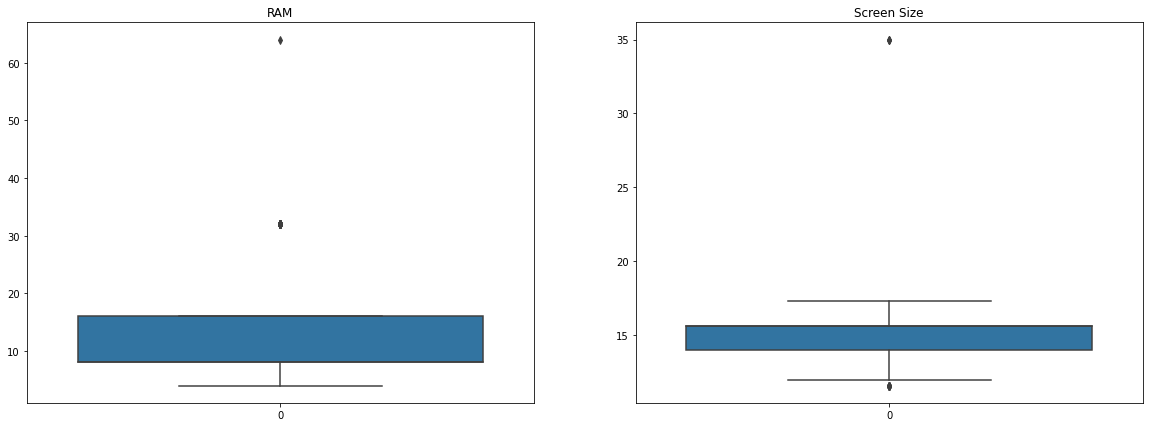

In [31]:
# Task 2 : Remove Outliers

fig, axs = plt.subplots(ncols=2, figsize = (20,7))

sns.boxplot(data = df['RAM'], ax = axs[0]).set_title('RAM')
df = df[df['RAM'] != 64]

sns.boxplot(data = df['ScreenSize'], ax = axs[1]).set_title('Screen Size')
df = df[df['ScreenSize'] != 35.00]

In [32]:
# Task 3 : Combining two/more columns to make a feature
df['PPI'] = np.sqrt(df['resX'] ** 2 + df['resY'] ** 2)/(df['ScreenSize'])
df.drop(['resX', 'resY', 'ScreenSize'], axis = 1, inplace = True)
df.PPI.fillna(df.PPI.mean(), inplace = True)

In [33]:
df.to_csv('Scraper-Data-Clean.csv')